<a href="https://colab.research.google.com/github/AymanMahfuz27/layer-freezing-gpt-finetune/blob/main/efficient_finetuning_of_an_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""
Efficient Fine-Tuning via Layer Freezing - Implementation
This script implements the layer freezing approach for efficient fine-tuning
of transformer models as described in the research paper.
"""

'\nEfficient Fine-Tuning via Layer Freezing - Implementation\nThis script implements the layer freezing approach for efficient fine-tuning\nof transformer models as described in the research paper.\n'

# Investigating Efficient Fine-Tuning of LLMs Through Selective Layer Adaptation

## Abstract

As the size of large language models (LLMs) continues to grow, full-parameter fine-tuning has become increasingly resource-intensive and impractical for many applications. Inspired by the hierarchical structure observed in deep convolutional networks, we hypothesize that LLMs also form layered abstractions — with lower layers specializing in syntactic patterns and higher layers specializing in semantic, task-specific reasoning. This work investigates whether fine-tuning only the uppermost layers of an LLM is sufficient for downstream task adaptation. We conduct controlled experiments comparing full fine-tuning to selective top-layer fine-tuning across a classification task. Our results suggest that significant training efficiency can be achieved with minimal degradation in performance, highlighting opportunities for lightweight model adaptation in resource-constrained settings.

## Hypothesis

Transformer-based language models exhibit hierarchical abstraction across their depth; therefore, fine-tuning only the final N layers of a pretrained LLM will yield comparable downstream performance to full fine-tuning while updating significantly fewer parameters.



# Install required packages<br>
import os<br>
os.system("pip install transformers datasets torch evaluate tqdm matplotlib pandas")

Imports

In [2]:
!pip uninstall -y nvidia-cublas-cu12 nvidia-cuda-cupti-cu12 nvidia-cuda-nvrtc-cu12 nvidia-cuda-runtime-cu12 nvidia-cudnn-cu12 nvidia-cufft-cu12 nvidia-curand-cu12 nvidia-cusolver-cu12 nvidia-cusparse-cu12 nvidia-nvtx-cu12

Found existing installation: nvidia-cublas-cu12 12.5.3.2
Uninstalling nvidia-cublas-cu12-12.5.3.2:
  Successfully uninstalled nvidia-cublas-cu12-12.5.3.2
Found existing installation: nvidia-cuda-cupti-cu12 12.5.82
Uninstalling nvidia-cuda-cupti-cu12-12.5.82:
  Successfully uninstalled nvidia-cuda-cupti-cu12-12.5.82
Found existing installation: nvidia-cuda-nvrtc-cu12 12.5.82
Uninstalling nvidia-cuda-nvrtc-cu12-12.5.82:
  Successfully uninstalled nvidia-cuda-nvrtc-cu12-12.5.82
Found existing installation: nvidia-cuda-runtime-cu12 12.5.82
Uninstalling nvidia-cuda-runtime-cu12-12.5.82:
  Successfully uninstalled nvidia-cuda-runtime-cu12-12.5.82
Found existing installation: nvidia-cudnn-cu12 9.3.0.75
Uninstalling nvidia-cudnn-cu12-9.3.0.75:
  Successfully uninstalled nvidia-cudnn-cu12-9.3.0.75
Found existing installation: nvidia-cufft-cu12 11.2.3.61
Uninstalling nvidia-cufft-cu12-11.2.3.61:
  Successfully uninstalled nvidia-cufft-cu12-11.2.3.61
Found existing installation: nvidia-curand-cu1

In [3]:
!pip install torch==2.6.0+cu124 --extra-index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00
  Attempting uninst

In [4]:
!pip install datasets evaluate peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [5]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EvalPrediction
)
from datasets import load_dataset
import evaluate
from peft import get_peft_model, LoraConfig, TaskType


Set seeds for reproducibility

In [6]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# set_seed()

Check for GPU

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Configuration

In [8]:
MODEL_NAME = "gpt2"
TASK = "boolq"
OUTPUT_DIR = "./results"
MAX_LENGTH = 256  # increased for BoolQ context/questions
BATCH_SIZE = 8    # reduce batch size due to increased max length (better for GPU memory)
LEARNING_RATE = 5e-5
NUM_EPOCHS = 3
WEIGHT_DECAY = 0.01


In [9]:
print(f"Model: {MODEL_NAME}")
print(f"Task: {TASK}")

Model: gpt2
Task: boolq


Load dataset

In [10]:
def load_and_prepare_dataset(task_name):
    """Load dataset from Hugging Face and prepare it for training"""
    print(f"Loading dataset: {task_name}")

    # Load BoolQ directly from Hugging Face
    if task_name == "boolq":
        dataset = load_dataset("boolq")
        num_labels = 2
        label_names = ["False", "True"]
    elif task_name == "mnli":
        dataset = load_dataset("mnli")
        num_labels = 3
        label_names = ["entailment", "neutral", "contradiction"]
    else:
        # Default for other tasks, or fallback to a known dataset
        dataset = load_dataset("boolq")
        num_labels = 2
        label_names = ["False", "True"]

    print(f"Dataset structure: {dataset}")
    return dataset, num_labels, label_names


Load tokenizer and model

In [11]:
def load_model_and_tokenizer(model_name, num_labels):
    """Load pretrained model and tokenizer"""
    print(f"Loading tokenizer: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Handle models without pad token (like GPT-2)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    print(f"Loading model: {model_name}")
    from transformers import GPT2ForSequenceClassification

    model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # GPT-2 needs special padding token handling
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token_id



    return model, tokenizer

In [12]:
# def preprocess_sciq_to_boolq(example):
#     # Just pick correct answer randomly as true/false example clearly
#     correct_answer = example['correct_answer']
#     passage = example['support']
#     question = example['question']
#     return {
#         "question": f"{question}",
#         "passage": passage,
#         "label": True  # Always true for correct answer passage
#     }

# # clearly preprocess SciQ
# boolq_like_sciq = dataset.map(preprocess_sciq_to_boolq)
# boolq_like_sciq = boolq_like_sciq["train"].train_test_split(test_size=0.1, seed=42)



Implement layer freezing

In [13]:
def freeze_layers(model, num_layers_to_freeze):
    """
    Freeze specific layers in GPT-2 explicitly and correctly.
    """
    print(f"Freezing {num_layers_to_freeze} GPT-2 layers...")

    total_params = sum(p.numel() for p in model.parameters())

    # GPT-2 transformer layers
    if hasattr(model, "transformer") and hasattr(model.transformer, "h"):
        layers_to_freeze = min(num_layers_to_freeze, len(model.transformer.h))
        for i in range(layers_to_freeze):
            for param in model.transformer.h[i].parameters():
                param.requires_grad = False
        print(f"Froze {layers_to_freeze} GPT-2 transformer layers")

    # Freeze embeddings explicitly (optional but recommended)
    for param in model.transformer.wte.parameters():
        param.requires_grad = False
    for param in model.transformer.wpe.parameters():
        param.requires_grad = False
    print("Embeddings frozen")

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    trainable_percentage = 100 * trainable_params / total_params

    print(f"Trainable parameters: {trainable_params:,} ({trainable_percentage:.2f}% of total)")
    print(f"Total parameters: {total_params:,}")

    return model, trainable_percentage


Preprocess the dataset

In [50]:
def preprocess_dataset(dataset, tokenizer, task_name):
    """Tokenize and prepare dataset for training"""
    # Define tokenization function based on task
    if task_name == "boolq":
      def tokenize_function(examples):
        questions = examples["question"]
        passages = examples["passage"]
        combined_input = [f"Question: {q}\nPassage: {p}\nAnswer:" for q, p in zip(questions, passages)]
        tokenized = tokenizer(
            combined_input,
            padding="max_length",
            truncation=True,
            max_length=MAX_LENGTH
        )
        # Convert boolean labels to int (0 or 1)
        tokenized["labels"] = [int(a) for a in examples["answer"]]
        return tokenized




    elif task_name == "mnli":
        # Sentence pair classification
        def tokenize_function(examples):
            return tokenizer(
                examples["premise"],
                examples["hypothesis"],
                padding="max_length",
                truncation=True,
                max_length=MAX_LENGTH
            )
    else:
        # Default approach for other tasks
        def tokenize_function(examples):
            # Check for sentence pairs
            if "sentence1" in examples and "sentence2" in examples:
                return tokenizer(
                    examples["sentence1"],
                    examples["sentence2"],
                    padding="max_length",
                    truncation=True,
                    max_length=MAX_LENGTH
                )
            # Single sentence
            elif "sentence" in examples:
                return tokenizer(
                    examples["sentence"],
                    padding="max_length",
                    truncation=True,
                    max_length=MAX_LENGTH
                )
            # Unknown format - try to use the first text field we find
            else:
                text_field = next(key for key in examples.keys() if isinstance(examples[key][0], str))
                return tokenizer(
                    examples[text_field],
                    padding="max_length",
                    truncation=True,
                    max_length=MAX_LENGTH
                )

    print("Tokenizing datasets...")
    tokenized_datasets = dataset.map(
        tokenize_function,
        batched=True,
        desc="Tokenizing",
    )

    # Set format for pytorch
    # For each split in the tokenized dataset, remove all columns except the ones we need.
    for split in tokenized_datasets.keys():
        tokenized_datasets[split] = tokenized_datasets[split].remove_columns(
            [col for col in tokenized_datasets[split].column_names if col not in ["input_ids", "attention_mask", "labels"]]
        )




    tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    print(f"Tokenized dataset structure: {tokenized_datasets}")

    return tokenized_datasets

Set up evaluation metrics

In [51]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions)
    }


Fine-tune the model

In [65]:
def fine_tune_model(model, tokenized_datasets, tokenizer, output_dir, num_epochs=3):
    """Fine-tune the model with the tokenized dataset"""
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=num_epochs,
        weight_decay=WEIGHT_DECAY,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none",  # Disable reporting to save space in Colab
        fp16=True,  # Enable mixed precision training
        remove_unused_columns=False,  # We'll handle this ourselves
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print("Starting fine-tuning...")
    train_result = trainer.train()
    print(f"Training completed. Results: {train_result.metrics}")

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")
    # Plot training loss
   # Extract steps and loss values from log_history
    steps = [entry["step"] for entry in trainer.state.log_history if "loss" in entry]
    losses = [entry["loss"] for entry in trainer.state.log_history if "loss" in entry]

    plt.plot(steps, losses)
    plt.title("Training Loss Curve")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "loss_curve.png"))
    plt.close()


    return trainer, eval_results

Run experiments with different layer freezing configurations

In [66]:
def run_layer_freezing_experiments(model_name, dataset_name, layer_configs, num_epochs=2):
    """
    Run experiments with different layer freezing configurations.

    Args:
        model_name: Name of the pre-trained model
        dataset_name: Name of the dataset to use
        layer_configs: List of number of layers to freeze in each experiment
        num_epochs: Number of epochs to train for each experiment

    Returns:
        DataFrame with results
    """
    results = []

    # Load dataset once
    dataset, num_labels, label_names = load_and_prepare_dataset(dataset_name)
    seeds = [42,52,62,72]
    for layers_to_freeze in layer_configs:
        for seed in seeds:
            set_seed(seed)
            experiment_name = f"{model_name.split('/')[-1]}_{layers_to_freeze}_frozen_{seed}"
            print(f"\n===== Experiment: {experiment_name} =====")

            # Load fresh model for each experiment
            model, tokenizer = load_model_and_tokenizer(model_name, num_labels)

            # Apply freezing
            model, trainable_pct = freeze_layers(model, layers_to_freeze)
            print(f"\nStarting fine-tuning with {trainable_pct:.2f}% parameters trainable.")


            # Prepare dataset
            tokenized_datasets = preprocess_dataset(dataset, tokenizer, dataset_name)

            # Fine-tune
            output_dir = os.path.join(OUTPUT_DIR, experiment_name)
            trainer, eval_results = fine_tune_model(
                model,
                tokenized_datasets,
                tokenizer,
                output_dir,
                num_epochs=num_epochs
            )

            # Record results
            result = {
                "model": model_name,
                "seeds": seed,
                "layers_frozen": layers_to_freeze,
                "trainable_params_pct": trainable_pct,
                "accuracy": float(eval_results.get("eval_accuracy", 0)),
                "loss": float(eval_results.get("eval_loss", 0)),
                "training_time": float(eval_results.get("eval_runtime", 0)),
            }


            results.append(result)
            print(f"Experiment results: {result}")

    # Create and return results dataframe
    results_df = pd.DataFrame(results)
    print("\n===== Summary of All Experiments =====")
    print(results_df)

    return results_df

In [76]:
def fine_tune_with_lora(model, tokenized_datasets, tokenizer, output_dir, num_epochs=3):
    # Define training arguments for LoRA fine-tuning
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=num_epochs,
        weight_decay=WEIGHT_DECAY,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none",  # Disable reporting to save space in Colab
        fp16=True,  # Enable mixed precision training
        remove_unused_columns=False,
    )

    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=8,
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules=["c_attn", "c_proj"]  # GPT-2 modules
    )

    model = get_peft_model(model, lora_config)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    train_result = trainer.train()
    eval_results = trainer.evaluate()

    return trainer, eval_results


Visualize results

In [77]:
def plot_results(results_df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    grouped = results_df.groupby("layers_frozen").agg({
        "accuracy": ["mean", "std"],
        "trainable_params_pct": "first"
    }).reset_index()
    grouped.columns = ["layers_frozen", "accuracy_mean", "accuracy_std", "trainable_params_pct"]

    plt.figure(figsize=(12, 5))

    # Accuracy vs. Layers Frozen with error bars
    plt.subplot(1, 2, 1)
    plt.errorbar(grouped["layers_frozen"], grouped["accuracy_mean"], yerr=grouped["accuracy_std"], fmt='o-', capsize=5)
    plt.xlabel("Layers Frozen")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Layers Frozen (mean ± std)")
    plt.grid(True)

    # Accuracy vs Trainable Parameters
    plt.subplot(1, 2, 2)
    plt.plot(grouped["trainable_params_pct"], grouped["accuracy_mean"], 'o-')
    plt.xlabel("Trainable Parameters (%)")
    plt.ylabel("Accuracy")
    plt.title("Trainable Params vs Accuracy")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "layer_freezing_results.png"))
    plt.show()


Function to test the model on sample text

In [78]:
def predict_sample_text(model, tokenizer, texts, label_names):
    """Make predictions on sample texts"""
    model.eval()
    results = []

    for text in texts:
        # Tokenize
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Get prediction and confidence
        pred_idx = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0, pred_idx].item()
        prediction = label_names[pred_idx]

        results.append({
            "text": text,
            "prediction": prediction,
            "confidence": confidence
        })

    for result in results:
        print(f"Text: {result['text']}")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print("-" * 50)

    return results

Main execution

In [79]:
def main():
    """Main function to run the experiments"""
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Load dataset
    dataset, num_labels, label_names = load_and_prepare_dataset("boolq")
    # Use BoolQ train split and create a validation split if not provided
    if "validation" not in dataset.keys():
        dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
    else:
        dataset = dataset

    # Run a single fine-tuning experiment
    print("\n===== Running Single Model Fine-Tuning =====")
    model, tokenizer = load_model_and_tokenizer(MODEL_NAME, num_labels)

    # Apply moderate layer freezing (adjust based on model size)
    # For BERT-base which has 12 layers, freeze 6 layers
    model, trainable_pct = freeze_layers(model, 8)

    # Preprocess the dataset
    tokenized_datasets = preprocess_dataset(dataset, tokenizer, "boolq")

    # Fine-tune the model
    trainer, eval_results = fine_tune_model(model, tokenized_datasets, tokenizer, OUTPUT_DIR)

    if "test" in dataset.keys():
        eval_subset = dataset["test"].select(range(100))
    else:
        eval_subset = dataset["validation"].select(range(100))


    example_texts = [
        f"Question: {x['question']}\nPassage: {x['passage']}\nAnswer:" for x in eval_subset
    ]




    predict_sample_text(model, tokenizer, example_texts, label_names)
    print("\n===== Running LoRA Fine-Tuning Baseline =====")
    model, tokenizer = load_model_and_tokenizer(MODEL_NAME, num_labels)
    tokenized_datasets = preprocess_dataset(dataset, tokenizer, TASK)
    trainer, eval_results = fine_tune_with_lora(model, tokenized_datasets, tokenizer, os.path.join(OUTPUT_DIR, "lora_baseline"))

    print(f"LoRA Fine-Tuning Results: {eval_results}")

    # Run experiments with different freezing configurations
    print("\n===== Running Layer Freezing Experiments =====")
    layer_configs = [0, 3, 6, 9]  # Try different freezing configurations
    results_df = run_layer_freezing_experiments(
        MODEL_NAME,
        TASK,
        layer_configs,
        num_epochs=2  # Fewer epochs for experiments
    )

    # Save results to CSV
    results_df.to_csv(os.path.join(OUTPUT_DIR, "layer_freezing_results.csv"), index=False)

    # Plot results
    plot_results(results_df)

    print("\n===== All experiments completed =====")

Run the main function

Loading dataset: boolq
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 3270
    })
})

===== Running Single Model Fine-Tuning =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 8 GPT-2 layers...
Froze 8 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 28,354,560 (22.79% of total)
Total parameters: 124,441,344
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.652600,0.634010,0.647095,0.761472
2,0.615600,0.620928,0.648318,0.733673
3,0.581000,0.629783,0.662080,0.748692


Training completed. Results: {'train_runtime': 420.5976, 'train_samples_per_second': 67.24, 'train_steps_per_second': 8.409, 'total_flos': 3694866701746176.0, 'train_loss': 0.6359391200330118, 'epoch': 3.0}


Evaluation results: {'eval_loss': 0.6297826170921326, 'eval_accuracy': 0.6620795107033639, 'eval_f1': 0.7486922901978622, 'eval_runtime': 21.1254, 'eval_samples_per_second': 154.79, 'eval_steps_per_second': 19.361, 'epoch': 3.0}
Text: Question: does ethanol take more energy make that produces
Passage: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
<ipython-input-76-949460c24d34>:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.663100,0.655978,0.620183,0.763429
2,0.647500,0.658936,0.611009,0.709456
3,0.639300,0.647821,0.617431,0.721319


LoRA Fine-Tuning Results: {'eval_loss': 0.655978262424469, 'eval_accuracy': 0.6201834862385321, 'eval_f1': 0.7634285714285715, 'eval_runtime': 25.0619, 'eval_samples_per_second': 130.477, 'eval_steps_per_second': 16.32, 'epoch': 3.0}

===== Running Layer Freezing Experiments =====
Loading dataset: boolq
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 3270
    })
})

===== Experiment: gpt2_0_frozen_42 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 0 GPT-2 layers...
Froze 0 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 85,057,536 (68.35% of total)
Total parameters: 124,441,344

Starting fine-tuning with 68.35% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.655600,0.637900,0.660245,0.779081
2,0.577500,0.606364,0.685015,0.757875


Training completed. Results: {'train_runtime': 478.3253, 'train_samples_per_second': 39.417, 'train_steps_per_second': 4.93, 'total_flos': 2463244467830784.0, 'train_loss': 0.6651641353901612, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6063637733459473, 'eval_accuracy': 0.6850152905198776, 'eval_f1': 0.7578749412317819, 'eval_runtime': 21.3123, 'eval_samples_per_second': 153.432, 'eval_steps_per_second': 19.191, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 42, 'layers_frozen': 0, 'trainable_params_pct': 68.35150864330106, 'accuracy': 0.6850152905198776, 'loss': 0.6063637733459473, 'training_time': 21.3123}

===== Experiment: gpt2_0_frozen_52 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 0 GPT-2 layers...
Froze 0 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 85,057,536 (68.35% of total)
Total parameters: 124,441,344

Starting fine-tuning with 68.35% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.655400,0.649788,0.645872,0.774269
2,0.584100,0.616565,0.674006,0.745342


Training completed. Results: {'train_runtime': 482.4312, 'train_samples_per_second': 39.081, 'train_steps_per_second': 4.888, 'total_flos': 2463244467830784.0, 'train_loss': 0.6333162341712388, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6165650486946106, 'eval_accuracy': 0.674006116207951, 'eval_f1': 0.7453416149068323, 'eval_runtime': 21.2913, 'eval_samples_per_second': 153.584, 'eval_steps_per_second': 19.21, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 52, 'layers_frozen': 0, 'trainable_params_pct': 68.35150864330106, 'accuracy': 0.674006116207951, 'loss': 0.6165650486946106, 'training_time': 21.2913}

===== Experiment: gpt2_0_frozen_62 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 0 GPT-2 layers...
Froze 0 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 85,057,536 (68.35% of total)
Total parameters: 124,441,344

Starting fine-tuning with 68.35% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.650700,0.645054,0.645566,0.773854
2,0.585700,0.613543,0.669113,0.744450


Training completed. Results: {'train_runtime': 468.4066, 'train_samples_per_second': 40.251, 'train_steps_per_second': 5.034, 'total_flos': 2463244467830784.0, 'train_loss': 0.6330325229376226, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6135426163673401, 'eval_accuracy': 0.6691131498470948, 'eval_f1': 0.7444496929617384, 'eval_runtime': 21.382, 'eval_samples_per_second': 152.933, 'eval_steps_per_second': 19.128, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 62, 'layers_frozen': 0, 'trainable_params_pct': 68.35150864330106, 'accuracy': 0.6691131498470948, 'loss': 0.6135426163673401, 'training_time': 21.382}

===== Experiment: gpt2_0_frozen_72 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 0 GPT-2 layers...
Froze 0 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 85,057,536 (68.35% of total)
Total parameters: 124,441,344

Starting fine-tuning with 68.35% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.659900,0.640261,0.644037,0.773453
2,0.596600,0.605362,0.677982,0.757205


Training completed. Results: {'train_runtime': 486.9838, 'train_samples_per_second': 38.716, 'train_steps_per_second': 4.842, 'total_flos': 2463244467830784.0, 'train_loss': 0.6357178109697208, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.605362057685852, 'eval_accuracy': 0.6779816513761467, 'eval_f1': 0.7572054415494581, 'eval_runtime': 21.4114, 'eval_samples_per_second': 152.722, 'eval_steps_per_second': 19.102, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 72, 'layers_frozen': 0, 'trainable_params_pct': 68.35150864330106, 'accuracy': 0.6779816513761467, 'loss': 0.605362057685852, 'training_time': 21.4114}

===== Experiment: gpt2_3_frozen_42 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 3 GPT-2 layers...
Froze 3 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 63,793,920 (51.26% of total)
Total parameters: 124,441,344

Starting fine-tuning with 51.26% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.660600,0.639381,0.662080,0.778335
2,0.597000,0.611104,0.683792,0.758411


Training completed. Results: {'train_runtime': 399.6372, 'train_samples_per_second': 47.178, 'train_steps_per_second': 5.9, 'total_flos': 2463244467830784.0, 'train_loss': 0.6679752081304005, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6111035943031311, 'eval_accuracy': 0.6837920489296636, 'eval_f1': 0.758411214953271, 'eval_runtime': 21.4242, 'eval_samples_per_second': 152.631, 'eval_steps_per_second': 19.091, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 42, 'layers_frozen': 3, 'trainable_params_pct': 51.26424864070899, 'accuracy': 0.6837920489296636, 'loss': 0.6111035943031311, 'training_time': 21.4242}

===== Experiment: gpt2_3_frozen_52 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 3 GPT-2 layers...
Froze 3 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 63,793,920 (51.26% of total)
Total parameters: 124,441,344

Starting fine-tuning with 51.26% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.648000,0.649817,0.657798,0.776334
2,0.590800,0.616664,0.687768,0.767691


Training completed. Results: {'train_runtime': 417.1236, 'train_samples_per_second': 45.2, 'train_steps_per_second': 5.653, 'total_flos': 2463244467830784.0, 'train_loss': 0.6349867480199554, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6166643500328064, 'eval_accuracy': 0.6877675840978593, 'eval_f1': 0.7676905574516496, 'eval_runtime': 21.5062, 'eval_samples_per_second': 152.05, 'eval_steps_per_second': 19.018, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 52, 'layers_frozen': 3, 'trainable_params_pct': 51.26424864070899, 'accuracy': 0.6877675840978593, 'loss': 0.6166643500328064, 'training_time': 21.5062}

===== Experiment: gpt2_3_frozen_62 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 3 GPT-2 layers...
Froze 3 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 63,793,920 (51.26% of total)
Total parameters: 124,441,344

Starting fine-tuning with 51.26% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.648400,0.623283,0.673089,0.775184
2,0.577200,0.608307,0.677064,0.751295


Training completed. Results: {'train_runtime': 399.2633, 'train_samples_per_second': 47.222, 'train_steps_per_second': 5.906, 'total_flos': 2463244467830784.0, 'train_loss': 0.6292530930173711, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6083067059516907, 'eval_accuracy': 0.6770642201834862, 'eval_f1': 0.7512953367875648, 'eval_runtime': 21.3394, 'eval_samples_per_second': 153.237, 'eval_steps_per_second': 19.166, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 62, 'layers_frozen': 3, 'trainable_params_pct': 51.26424864070899, 'accuracy': 0.6770642201834862, 'loss': 0.6083067059516907, 'training_time': 21.3394}

===== Experiment: gpt2_3_frozen_72 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 3 GPT-2 layers...
Froze 3 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 63,793,920 (51.26% of total)
Total parameters: 124,441,344

Starting fine-tuning with 51.26% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.637100,0.616341,0.667890,0.764425
2,0.585000,0.613144,0.674312,0.748524


Training completed. Results: {'train_runtime': 404.6905, 'train_samples_per_second': 46.589, 'train_steps_per_second': 5.827, 'total_flos': 2463244467830784.0, 'train_loss': 0.6231994564195524, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6131442189216614, 'eval_accuracy': 0.6743119266055045, 'eval_f1': 0.7485242030696576, 'eval_runtime': 21.5231, 'eval_samples_per_second': 151.929, 'eval_steps_per_second': 19.003, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 72, 'layers_frozen': 3, 'trainable_params_pct': 51.26424864070899, 'accuracy': 0.6743119266055045, 'loss': 0.6131442189216614, 'training_time': 21.5231}

===== Experiment: gpt2_6_frozen_42 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 6 GPT-2 layers...
Froze 6 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 42,530,304 (34.18% of total)
Total parameters: 124,441,344

Starting fine-tuning with 34.18% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.654500,0.625922,0.666972,0.778072
2,0.603000,0.621884,0.666055,0.738756


Training completed. Results: {'train_runtime': 330.7262, 'train_samples_per_second': 57.008, 'train_steps_per_second': 7.13, 'total_flos': 2463244467830784.0, 'train_loss': 0.6743621373196796, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6259219646453857, 'eval_accuracy': 0.6669724770642201, 'eval_f1': 0.7780721418381903, 'eval_runtime': 21.3244, 'eval_samples_per_second': 153.345, 'eval_steps_per_second': 19.18, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 42, 'layers_frozen': 6, 'trainable_params_pct': 34.176988638116924, 'accuracy': 0.6669724770642201, 'loss': 0.6259219646453857, 'training_time': 21.3244}

===== Experiment: gpt2_6_frozen_52 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 6 GPT-2 layers...
Froze 6 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 42,530,304 (34.18% of total)
Total parameters: 124,441,344

Starting fine-tuning with 34.18% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.647200,0.628073,0.664832,0.769166
2,0.591400,0.623879,0.671865,0.752251


Training completed. Results: {'train_runtime': 332.7416, 'train_samples_per_second': 56.663, 'train_steps_per_second': 7.087, 'total_flos': 2463244467830784.0, 'train_loss': 0.6362680268550546, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6238793134689331, 'eval_accuracy': 0.6718654434250765, 'eval_f1': 0.7522512121911799, 'eval_runtime': 21.2947, 'eval_samples_per_second': 153.56, 'eval_steps_per_second': 19.207, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 52, 'layers_frozen': 6, 'trainable_params_pct': 34.176988638116924, 'accuracy': 0.6718654434250765, 'loss': 0.6238793134689331, 'training_time': 21.2947}

===== Experiment: gpt2_6_frozen_62 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 6 GPT-2 layers...
Froze 6 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 42,530,304 (34.18% of total)
Total parameters: 124,441,344

Starting fine-tuning with 34.18% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.639300,0.643954,0.666972,0.778253
2,0.584700,0.611707,0.680122,0.764096


Training completed. Results: {'train_runtime': 331.2607, 'train_samples_per_second': 56.916, 'train_steps_per_second': 7.118, 'total_flos': 2463244467830784.0, 'train_loss': 0.6296575544646881, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6117072701454163, 'eval_accuracy': 0.6801223241590214, 'eval_f1': 0.7640956247180875, 'eval_runtime': 21.4785, 'eval_samples_per_second': 152.245, 'eval_steps_per_second': 19.042, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 62, 'layers_frozen': 6, 'trainable_params_pct': 34.176988638116924, 'accuracy': 0.6801223241590214, 'loss': 0.6117072701454163, 'training_time': 21.4785}

===== Experiment: gpt2_6_frozen_72 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 6 GPT-2 layers...
Froze 6 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 42,530,304 (34.18% of total)
Total parameters: 124,441,344

Starting fine-tuning with 34.18% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.644000,0.621774,0.665749,0.772907
2,0.587900,0.614346,0.675229,0.755074


Training completed. Results: {'train_runtime': 324.6678, 'train_samples_per_second': 58.072, 'train_steps_per_second': 7.263, 'total_flos': 2463244467830784.0, 'train_loss': 0.6282497338059597, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6143456697463989, 'eval_accuracy': 0.6752293577981652, 'eval_f1': 0.7550738007380073, 'eval_runtime': 21.2906, 'eval_samples_per_second': 153.589, 'eval_steps_per_second': 19.21, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 72, 'layers_frozen': 6, 'trainable_params_pct': 34.176988638116924, 'accuracy': 0.6752293577981652, 'loss': 0.6143456697463989, 'training_time': 21.2906}

===== Experiment: gpt2_9_frozen_42 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 9 GPT-2 layers...
Froze 9 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 21,266,688 (17.09% of total)
Total parameters: 124,441,344

Starting fine-tuning with 17.09% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.661000,0.639134,0.628440,0.750154
2,0.629100,0.635892,0.635474,0.736516


Training completed. Results: {'train_runtime': 265.4696, 'train_samples_per_second': 71.021, 'train_steps_per_second': 8.882, 'total_flos': 2463244467830784.0, 'train_loss': 0.7092149328437268, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6358919739723206, 'eval_accuracy': 0.635474006116208, 'eval_f1': 0.7365163572060124, 'eval_runtime': 21.6481, 'eval_samples_per_second': 151.052, 'eval_steps_per_second': 18.893, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 42, 'layers_frozen': 9, 'trainable_params_pct': 17.089728635524864, 'accuracy': 0.635474006116208, 'loss': 0.6358919739723206, 'training_time': 21.6481}

===== Experiment: gpt2_9_frozen_52 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 9 GPT-2 layers...
Froze 9 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 21,266,688 (17.09% of total)
Total parameters: 124,441,344

Starting fine-tuning with 17.09% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.661400,0.645313,0.628746,0.761024
2,0.624000,0.640688,0.630581,0.737277


Training completed. Results: {'train_runtime': 255.0423, 'train_samples_per_second': 73.925, 'train_steps_per_second': 9.246, 'total_flos': 2463244467830784.0, 'train_loss': 0.6563806250704053, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6406880021095276, 'eval_accuracy': 0.6305810397553517, 'eval_f1': 0.7372770769899957, 'eval_runtime': 21.4903, 'eval_samples_per_second': 152.162, 'eval_steps_per_second': 19.032, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 52, 'layers_frozen': 9, 'trainable_params_pct': 17.089728635524864, 'accuracy': 0.6305810397553517, 'loss': 0.6406880021095276, 'training_time': 21.4903}

===== Experiment: gpt2_9_frozen_62 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 9 GPT-2 layers...
Froze 9 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 21,266,688 (17.09% of total)
Total parameters: 124,441,344

Starting fine-tuning with 17.09% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.650700,0.638234,0.638532,0.755684
2,0.611000,0.634570,0.636697,0.723721


Training completed. Results: {'train_runtime': 260.5154, 'train_samples_per_second': 72.372, 'train_steps_per_second': 9.051, 'total_flos': 2463244467830784.0, 'train_loss': 0.6468502817970904, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.63823401927948, 'eval_accuracy': 0.6385321100917432, 'eval_f1': 0.7556841670111616, 'eval_runtime': 21.3948, 'eval_samples_per_second': 152.841, 'eval_steps_per_second': 19.117, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 62, 'layers_frozen': 9, 'trainable_params_pct': 17.089728635524864, 'accuracy': 0.6385321100917432, 'loss': 0.63823401927948, 'training_time': 21.3948}

===== Experiment: gpt2_9_frozen_72 =====
Loading tokenizer: gpt2
Loading model: gpt2


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-65-f03aad642d44>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Freezing 9 GPT-2 layers...
Froze 9 GPT-2 transformer layers
Embeddings frozen
Trainable parameters: 21,266,688 (17.09% of total)
Total parameters: 124,441,344

Starting fine-tuning with 17.09% parameters trainable.
Tokenizing datasets...
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3270
    })
})
Starting fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.654200,0.639355,0.640061,0.762941
2,0.621500,0.631487,0.648318,0.738992


Training completed. Results: {'train_runtime': 257.0409, 'train_samples_per_second': 73.35, 'train_steps_per_second': 9.174, 'total_flos': 2463244467830784.0, 'train_loss': 0.6485300557506196, 'epoch': 2.0}


Evaluation results: {'eval_loss': 0.6314868330955505, 'eval_accuracy': 0.6483180428134556, 'eval_f1': 0.7389922832501135, 'eval_runtime': 21.4955, 'eval_samples_per_second': 152.125, 'eval_steps_per_second': 19.027, 'epoch': 2.0}
Experiment results: {'model': 'gpt2', 'seeds': 72, 'layers_frozen': 9, 'trainable_params_pct': 17.089728635524864, 'accuracy': 0.6483180428134556, 'loss': 0.6314868330955505, 'training_time': 21.4955}

===== Summary of All Experiments =====
   model  seeds  layers_frozen  trainable_params_pct  accuracy      loss  \
0   gpt2     42              0             68.351509  0.685015  0.606364   
1   gpt2     52              0             68.351509  0.674006  0.616565   
2   gpt2     62              0             68.351509  0.669113  0.613543   
3   gpt2     72              0             68.351509  0.677982  0.605362   
4   gpt2     42              3             51.264249  0.683792  0.611104   
5   gpt2     52              3             51.264249  0.687768  0.616664 

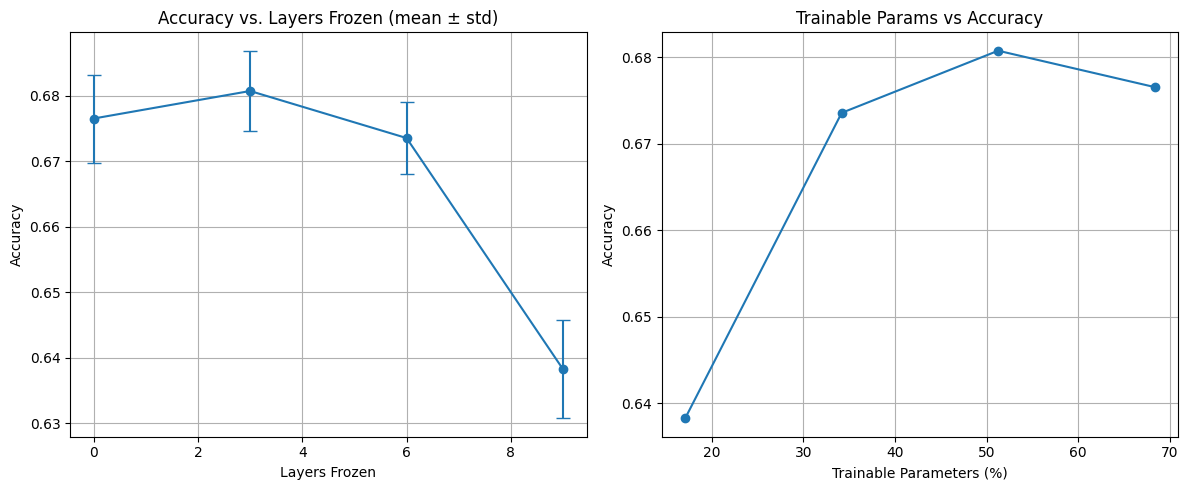


===== All experiments completed =====


In [80]:
if __name__ == "__main__":
    import os
    main()